# Chapter 2 - Exploratory Data Analysis
## Stable versus unstable QB statistics

Stability is important when evaluating anything, especially in sports. Stability is important when evaluating anything, especially in sports. This is because stability measures provide a comparative way to determine how much of a skill is fundamental to the player - how much of what happened in a given setting is transferable to another setting - and how much of past performance can be attributed to variance.

In the words of FiveThirtyEight founder Nate Silver: "Stability analysis helps us tease apart what is signal and what is noise."

If a player does very well in the stable components of football but poorly in the unstable ones, they might be a buy-low candidate - a player who is underrated in the marketplace. The opposite, a player who performs well in the unstable metrics but poorly in the stable ones, might be a sell-high player.

Exact definitions of stability vary based on specific contexts, but in this book we refer to the stability of an evaluation metric as the metric's consistency over a predetermined time frame. For example, for fantasy football analysts, that time frame might be week to week, while for an analyst building a draft model for a team, it might be from a player's final few seasons in college to his first few seasons as a pro.

### Defining Questions

Asking the right questions is as important as solving them. Learning to ask the right question is a process honed by learning from asking the wrong questions. Positive results are the spoils earned from fighting through countless negative results.

To be scientific, a question needs to be about a hypothesis that is both testable and falsifiable. For example, "Throwing deep passes is more valuable than short passes, but it's difficult to say whether or not a QB is good at deep passes" is a reasonable hypothesis, but to make it scientific, you need to define what "valuable" means and what you mean when we say a player is "good" (or "bad") at deep passes. To that aim, you need data.

### Obtaining and Filtering Data

In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl

In [2]:
seasons = range(2016, 2022 + 1)
pbp_py = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [3]:
# filter to only passing plays
pbp_py_p = pbp_py.query("play_type == 'pass' & air_yards.notnull()").reset_index()

In [4]:
# long pass >= 20 air yards
# short pass < 20 air yards
# replace incomplete passing yards (from NULL to 0)
pbp_py_p["pass_length_air_yards"] = np.where(pbp_py_p["air_yards"] >= 20,
                                            "long", "short")

pbp_py_p["passing_yards"] = np.where(pbp_py_p["passing_yards"].isnull(),
                                    0, pbp_py_p["passing_yards"])

In [5]:
pbp_py_p["passing_yards"].describe()

count    131606.000000
mean          7.192111
std           9.667647
min         -20.000000
25%           0.000000
50%           5.000000
75%          11.000000
max          98.000000
Name: passing_yards, dtype: float64

In [6]:
# summarize short passes
pbp_py_p.query('pass_length_air_yards == "short"')["passing_yards"].describe()

count    116087.000000
mean          6.526812
std           7.695791
min         -20.000000
25%           0.000000
50%           5.000000
75%          10.000000
max          95.000000
Name: passing_yards, dtype: float64

In [7]:
# summarize long passes
pbp_py_p.query('pass_length_air_yards == "long"')["passing_yards"].describe()

count    15519.000000
mean        12.168761
std         17.923370
min          0.000000
25%          0.000000
50%          0.000000
75%         26.000000
max         98.000000
Name: passing_yards, dtype: float64

In [8]:
# summarize short pass EPA
pbp_py_p.query('pass_length_air_yards == "short"')["epa"].describe()

count    116086.000000
mean          0.119606
std           1.426229
min         -13.031219
25%          -0.606135
50%          -0.002100
75%           0.959107
max           8.241420
Name: epa, dtype: float64

In [9]:
# summarize long pass EPA
pbp_py_p.query('pass_length_air_yards == "long"')["epa"].describe()

count    15519.000000
mean         0.382649
std          2.185549
min        -10.477921
25%         -0.827421
50%         -0.465344
75%          2.136431
max          8.789743
Name: epa, dtype: float64

### Plotting Data

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

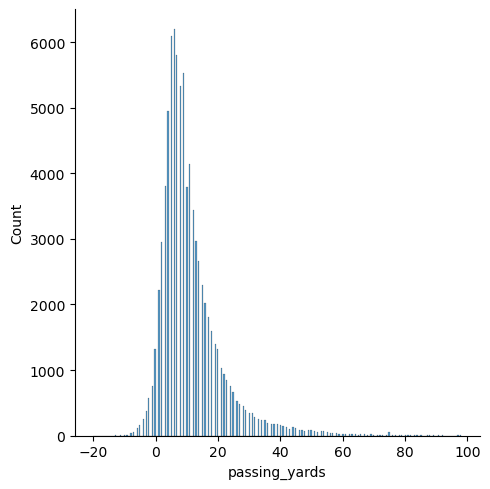

In [11]:
sns.displot(data=pbp_py, x="passing_yards")
plt.show()

In [12]:
sns.set_theme(style="whitegrid", palette="colorblind")

# filter short passes
pbp_py_p_short = pbp_py_p.query('pass_length_air_yards == "short"')

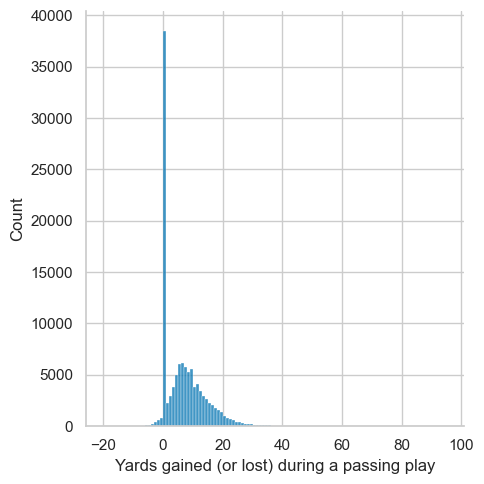

In [13]:
# create histogram & change labels
pbp_py_hist_short = sns.displot(data=pbp_py_p_short, binwidth=1,
                             x="passing_yards")
pbp_py_hist_short.set_axis_labels(
    "Yards gained (or lost) during a passing play", "Count")
plt.show()

In [1]:
# repeat above w/ EPA
pbp_py_hist_short = sns.displot(data=pbp_py_p_short, binwidth=1,
                             x="epa")
pbp_py_hist_short.set_axis_labels(
    "Yards gained (or lost) during a passing play", "Count")
plt.show()

NameError: name 'sns' is not defined

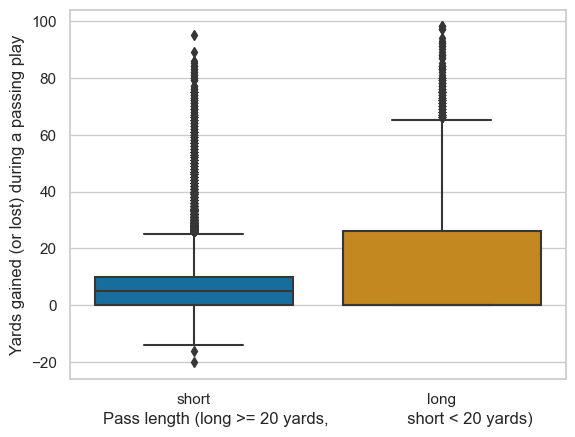

In [15]:
# boxplot
pass_boxplot = sns.boxplot(data=pbp_py_p, x="pass_length_air_yards",
                          y="passing_yards")

pass_boxplot.set(xlabel="Pass length (long >= 20 yards,\
                 short < 20 yards)",
                 ylabel="Yards gained (or lost) during a passing play")
plt.show()

### Player-level stability of passing yards per attempt

In [16]:
# aggregate data by player and season
pbp_py_p_s = pbp_py_p.groupby(["passer_id", "passer", "season"])\
                        .agg({"passing_yards": ["mean", "count"]})

# collapse the columns to make the df easier to handle
pbp_py_p_s.columns = list(map("_".join, pbp_py_p_s.columns.values))

In [17]:
# rename the columns to shorter, more intuitive names
pbp_py_p_s.rename(columns={'passing_yards_mean': 'ypa',
                          'passing_yards_count': 'n'},
                 inplace=True)

In [18]:
# filter out players w/ < 100 passing attempts in a season
pbp_py_p_s_100 = pbp_py_p_s.query("n >= 100").sort_values(by=["ypa"],
                                                         ascending=False)

In [19]:
pbp_py_p_s_100.head(20)

,,,ypa,n
passer_id,passer,season,,
00-0023682,R.Fitzpatrick,2018,9.617887,246
00-0026143,M.Ryan,2016,9.442155,631
00-0029701,R.Tannehill,2019,9.069971,343
00-0033537,D.Watson,2020,8.898524,542
00-0036212,T.Tagovailoa,2022,8.892231,399
00-0031345,J.Garoppolo,2017,8.863636,176
00-0033873,P.Mahomes,2018,8.709678,651
00-0036442,J.Burrow,2021,8.673748,659
00-0026498,M.Stafford,2019,8.647058,289


In [20]:
# pbp = play-by-play
# language = python
# passing play = p
# seasons data = s
# pass length = pl
pbp_py_p_s_pl = pbp_py_p.groupby(["passer_id", "passer", "season",
                                 "pass_length_air_yards"])\
                .agg({"passing_yards": ["mean", "count"]})

In [21]:
pbp_py_p_s_pl.head()

passing_yards      
                                                         mean count
passer_id  passer  season pass_length_air_yards                    
00-0019596 T.Brady 2016   long                      15.768116    69
                          short                      7.163022   503
                   2017   long                      13.264706   102
                          short                      7.071429   616
                   2018   long                      10.232877    73

In [24]:
# column name cleanup
pbp_py_p_s_pl.columns = list(map("_".join,
                                pbp_py_p_s_pl.columns.values))
pbp_py_p_s_pl.rename(columns={'passing_yards_mean': 'ypa',
                             'passing_yards_count': 'n'},
                    inplace=True)
#reset index
pbp_py_p_s_pl.reset_index(inplace=True)

In [26]:
pbp_py_p_s_pl.sort_values(by="ypa", ascending=False).head()

,passer_id,passer,season,pass_length_air_yards,ypa,n
1081,00-0035544,T.Kennedy,2021,long,75.0,1
806,00-0033132,K.Byard,2018,short,66.0,1
765,00-0033098,C.Jones,2016,long,64.0,1
1187,00-0036929,I.Book,2021,long,56.0,1
620,00-0031503,J.Winston,2020,long,56.0,1


In [28]:
# remove players w/ < 100 short passes in a season
# remove players w/ < 30 long passes in a season
q_value = ('(n >= 100 & ' + 'pass_length_air_yards == "short") | ' +
          '(n >= 30 & ' + 'pass_length_air_yards == "long")'
          )
pbp_py_p_s_pl = pbp_py_p_s_pl.query(q_value).reset_index()

# create list of columns to save (cols_save) and a new df w/ only these columns (air_yards_py)
# include .copy so edits will not be passed back to original df
cols_save = ["passer_id", "passer", "season", "pass_length_air_yards", "ypa"]
air_yards_py = pbp_py_p_s_pl[cols_save].copy()

In [29]:
# copy air_yards_py to create air_yards_lag_py
# take the current season value and add 1 by using the += command
# rename passing_yards_mean to include lag
air_yards_lag_py = air_yards_py.copy()
air_yards_lag_py["season"] += 1
air_yards_lag_py.rename(columns={'ypa': 'ypa_last'}, inplace=True)

In [30]:
# merge the two df together to create air_yards_both_py
# using an inner join so only shared years will be saved
# join on passer_id, passer, season & pass_length_air_yards
pbp_py_p_s_pl = air_yards_py.merge(air_yards_lag_py, how='inner', 
                                  on=["passer_id", "passer", "season", "pass_length_air_yards"])

In [31]:
# check your results
print(pbp_py_p_s_pl[["pass_length_air_yards", "passer", "season", "ypa", "ypa_last"]]\
                    .query('passer == "T.Brady" | passer == "A.Rodgers"')\
                    .sort_values(["passer", "pass_length_air_yards", "season"])\
                    .to_string()
)

   pass_length_air_yards     passer  season        ypa   ypa_last
47                  long  A.Rodgers    2019  12.092592  12.011628
49                  long  A.Rodgers    2020  16.097826  12.092592
51                  long  A.Rodgers    2021  14.302631  16.097826
53                  long  A.Rodgers    2022  10.312500  14.302631
45                 short  A.Rodgers    2017   6.041475   6.693523
46                 short  A.Rodgers    2018   6.697446   6.041475
48                 short  A.Rodgers    2019   6.207224   6.697446
50                 short  A.Rodgers    2020   6.718447   6.207224
52                 short  A.Rodgers    2021   6.777083   6.718447
54                 short  A.Rodgers    2022   6.239130   6.777083
0                   long    T.Brady    2017  13.264706  15.768116
2                   long    T.Brady    2018  10.232877  13.264706
4                   long    T.Brady    2019  10.828571  10.232877
6                   long    T.Brady    2020  12.252101  10.828571
8         

In [32]:
pbp_py_p_s_pl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317 entries, 0 to 316
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   passer_id              317 non-null    object 
 1   passer                 317 non-null    object 
 2   season                 317 non-null    int64  
 3   pass_length_air_yards  317 non-null    object 
 4   ypa                    317 non-null    float32
 5   ypa_last               317 non-null    float32
dtypes: float32(2), int64(1), object(3)
memory usage: 14.9+ KB


In [33]:
# how many unique passers do we have?
len(pbp_py_p_s_pl.passer_id.unique())

65

<Axes: xlabel='ypa', ylabel='ypa_last'>

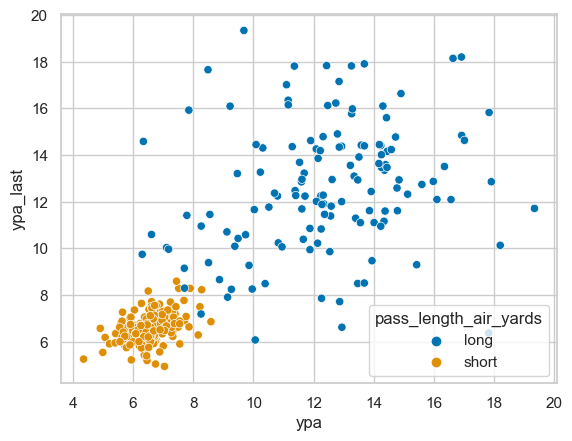

In [35]:
sns.scatterplot(data=pbp_py_p_s_pl, x="ypa", y="ypa_last", hue="pass_length_air_yards")

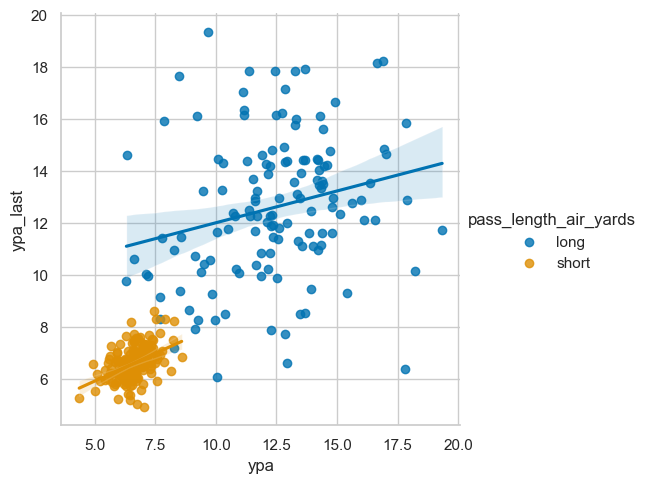

In [37]:
sns.lmplot(data=pbp_py_p_s_pl, x="ypa", y="ypa_last", hue="pass_length_air_yards")
plt.show()

In [38]:
# correlation
pbp_py_p_s_pl.query("ypa.notnull() & ypa_last.notnull()")\
                    .groupby("pass_length_air_yards")[["ypa", "ypa_last"]].corr()

ypa  ypa_last
pass_length_air_yards                             
long                  ypa       1.000000  0.233890
                      ypa_last  0.233890  1.000000
short                 ypa       1.000000  0.438479
                      ypa_last  0.438479  1.000000

A QB's performance on shorter passes is nearly twice as stable as on longer passes.

In [39]:
# 2017 leaderboard for deep passing YPA
pbp_py_p_s_pl.query('pass_length_air_yards == "long" & season == 2017')\
                    [["passer_id", "passer", "ypa"]]\
                    .sort_values(["ypa"], ascending=False).head(10)

,passer_id,passer,ypa
41,00-0023436,A.Smith,19.338236
79,00-0026498,M.Stafford,17.830769
12,00-0020531,D.Brees,16.632353
191,00-0032950,C.Wentz,13.555555
33,00-0022942,P.Rivers,13.347826
0,00-0019596,T.Brady,13.264706
129,00-0029604,K.Cousins,12.847458
114,00-0029263,R.Wilson,12.738636
203,00-0033077,D.Prescott,12.585366
109,00-0028986,C.Keenum,11.904762


In [40]:
# 2018 leaderboard for deep passing YPA
pbp_py_p_s_pl.query('pass_length_air_yards == "long" & season == 2018')\
                    [["passer_id", "passer", "ypa"]]\
                    .sort_values(["ypa"], ascending=False).head(10)

,passer_id,passer,ypa
116,00-0029263,R.Wilson,15.597403
14,00-0020531,D.Brees,14.903226
205,00-0033077,D.Prescott,14.771930
214,00-0033106,J.Goff,14.445946
35,00-0022942,P.Rivers,14.357142
157,00-0031280,D.Carr,14.339286
188,00-0032268,M.Mariota,13.941176
64,00-0026143,M.Ryan,13.465754
193,00-0032950,C.Wentz,13.222222
24,00-0022803,E.Manning,12.941176


## Exercises

1) Create the same histograms but for EPA per pass attempt.

2) Create the same boxplots but for EPA per pass attempt.

3) Perform the same stability analysis but for EPA per pass attempt.
    - Do you see the same qualitative results as when you use YPA?
    - Do any players have similar YPA numbers one year to the next but have drastically different EPA per pass
        attempt numbers across years? Where could these differences come from?

4) One of the reasons that data for long pass attempts is less stable than short pass attempts is that there are fewer of them, which is largely a product of 20 yards being an arbitrary cutoff for long passes. Find a cutoff that equally splits the data and perform the same analysis. Do the results stay the same?